# Dataset preparation, baseline model and Temporal Fusion Transformer

Preparo el dataset para el modelo predictivo: 
- Agrupo ventas por producto y por día
- Agrego información climática y de feriados
- Agrego variables lag y relacionadas con la fecha

Modelo baseline: 7-days Moving Average
- Obtengo predicciones y evalúo

Modelo predictivo: Temporal Fusion Transformer
- Escalo variables numéricas
- Defino el modelo, training y validation
- Evalúo predicciones en validation
- Guardo el modelo
- Optimización de hiperparámetros -> Después de muchas horas de ejecución se cierra el programa

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from gdrive import drive_list_files, download_from_drive, check_existing_file
from argholidays import get_arg_holidays

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import joblib

from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer

from pytorch_forecasting.metrics import MAE, QuantileLoss

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import torch

import warnings
warnings.filterwarnings('ignore')

### Preparación del dataset

Importo las ventas

In [34]:
folder_id = '1uepuL5iCVYies7GrC1YOW9Fws3NxA-Ex'
file_name = 'sales.csv'
existing_files = drive_list_files(folder_id)
    
for file in existing_files:
    if file['title'] == file_name:
        file_id = file['id']
        break

if file_id:
    file_path = download_from_drive(file_id, file_name)

    df = pd.read_csv(file_path)
    
df.head()

,createdAt,quantity,product,category
0,2019-10-26,1.0,Coca Cola,Sin alcohol
1,2019-10-26,1.0,Agua con gas,Sin alcohol
2,2019-10-26,1.0,Expresso,Cafetería
3,2019-10-26,1.0,Americano,Cafetería
4,2019-10-26,2.0,Medialuna,Desayunos y meriendas


Análisis descriptivo. Miro fechas y cantidad de productos distintos

In [35]:
oldest_date = df['createdAt'].min()
earliest_date = df['createdAt'].max()

print(f'Fecha más antigua: {oldest_date}')
print(f'Fecha más reciente: {earliest_date}')

distinct_products = df['product'].nunique()
print(f'Cantidad de productos distintos: {distinct_products}')

Fecha más antigua: 2019-10-26
Fecha más reciente: 2024-07-21
Cantidad de productos distintos: 262


Me quedo sólo con las fechas posteriores al 1 de enero de 2021, y anteriores al 1 de julio de 2024

In [36]:
date_filter = pd.Timestamp('2021-01-01')
df['createdAt'] = pd.to_datetime(df['createdAt'])
df = df[df['createdAt'] >= date_filter]

date_filter = pd.Timestamp('2024-07-01')
df = df[df['createdAt'] < date_filter]


oldest_date = df['createdAt'].min()
earliest_date = df['createdAt'].max()

print(f'Fecha más antigua: {oldest_date}')
print(f'Fecha más reciente: {earliest_date}')

distinct_products = df['product'].nunique()
print(f'Cantidad de productos distintos: {distinct_products}')

Fecha más antigua: 2021-01-01 00:00:00
Fecha más reciente: 2024-06-30 00:00:00
Cantidad de productos distintos: 261


Limpio categorías que no necesitan "producción" (ej: Coca Cola, Heineken, preparaciones que se hacen en el momento).

In [37]:
exclude_categories = ['Cafetería', 'Sin alcohol', 'Tragos con alcohol', 'Cervezas', 'Vinos', 'Whiskies y licores', 'Adicionales', 'Guarniciones', 'Platos especiales', 'Para picar']

df = df[~df['category'].isin(exclude_categories)]

distinct_products = df['product'].nunique()
print(f'Cantidad de productos distintos: {distinct_products}')

unique_categories = df['category'].unique()
print(f'\nCategorías: {unique_categories}')

Cantidad de productos distintos: 94

Categorías: ['Pizzas' 'Sándwiches' 'Desayunos y meriendas' 'Dulces y postres'
 'Minutas' 'Pastas' 'Ensaladas' 'Tartas']


Agrupo por cantidad de productos vendidos

In [38]:
# Agrupo por product y sumo los valores de quantity
df_grouped = df.groupby('product')['quantity'].sum().reset_index()

# Ordeno por quantity
df_sorted = df_grouped.sort_values(by='quantity', ascending=False)

# Mejores 5
top_5_mayor = df_sorted.head()
print('Top 5 productos con mayor cantidad:')
print(top_5_mayor)

# Peores 5
top_5_menor = df_sorted.tail()
print('\nTop 5 productos con menor cantidad:')
print(top_5_menor)

Top 5 productos con mayor cantidad:
                        product  quantity
88                  Tostado JyQ   12138.0
37                    Medialuna    8704.0
38  Medialuna con jamon y queso    5804.0
49                     Para dos    4599.0
16               Desayuno Campo    4355.0

Top 5 productos con menor cantidad:
                            product  quantity
77  Tarta de jamon y queso sin tacc      11.0
82       Tarta de verduras sin tacc       8.0
83  Tarta gelatina y crema sin tacc       7.0
79        Tarta de manzana sin tacc       4.0
61              Porción de tostadas       2.0


Me quedo sólo con los primeros 5 para agilizar el proceso

In [39]:
# Selecciono los nombres de los productos más vendidos
top_product_names = top_5_mayor['product'].tolist()

# Filtro el dataframe original para quedarme solo con los productos más vendidos
df_top_products = df[df['product'].isin(top_product_names)]

Agrupo las ventas por día y producto. Completo los días sin ventas con quantity = 0

In [40]:
df = df_top_products.copy()

# Agrupo por día y producto
df = df.groupby(['createdAt', 'product'])['quantity'].sum().reset_index()

# Renombro y me aseguro que la columna tenga formato fecha
df.rename(columns={'createdAt': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Creo un rango de fechas entre el primer y último día
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# Creo un dataframe con todas las combinaciones de productos y fechas
all_products = df['product'].unique()
full_grid = pd.MultiIndex.from_product([all_products, date_range], names=['product', 'date']).to_frame(index=False)

# Mergeo con el original
df = pd.merge(full_grid, df, on=['product', 'date'], how='left')

# Relleno los valores faltantes de quantity con 0
df['quantity'] = df['quantity'].fillna(0)

# Ordeno por producto y fecha
df = df.sort_values(by=['product', 'date']).reset_index(drop=True)

df['quantity'] = df['quantity'].astype(int)

print(all_products)

print(df)

['Medialuna' 'Tostado JyQ' 'Medialuna con jamon y queso' 'Para dos'
 'Desayuno Campo']
             product       date  quantity
0     Desayuno Campo 2021-01-01         0
1     Desayuno Campo 2021-01-02         0
2     Desayuno Campo 2021-01-03         0
3     Desayuno Campo 2021-01-04         0
4     Desayuno Campo 2021-01-05         0
...              ...        ...       ...
6380     Tostado JyQ 2024-06-26         3
6381     Tostado JyQ 2024-06-27         9
6382     Tostado JyQ 2024-06-28         6
6383     Tostado JyQ 2024-06-29         9
6384     Tostado JyQ 2024-06-30        14

[6385 rows x 3 columns]


Chequeo que todos los productos tengan la misma cantidad de filas

In [41]:
product_count = df['product'].value_counts()

# Producto con más ocurrencias
producto_max = product_count.idxmax()
max_ocurrencias = product_count.max()

# Producto con menos ocurrencias
producto_min = product_count.idxmin()
min_ocurrencias = product_count.min()

print(f"Producto con más ocurrencias: {producto_max} ({max_ocurrencias} veces)")
print(f"Producto con menos ocurrencias: {producto_min} ({min_ocurrencias} veces)")

Producto con más ocurrencias: Desayuno Campo (1277 veces)
Producto con menos ocurrencias: Desayuno Campo (1277 veces)


Traigo los feriados de Argentina

In [42]:
df_holidays = get_arg_holidays(start_year=2021, end_year=2024)

df_holidays.head()

,date,holiday
0,2021-01-01,1
1,2021-02-15,1
2,2021-02-16,1
3,2021-03-24,1
4,2021-04-02,1


Mergeo con el dataframe original

In [43]:
df_full = pd.merge(df, df_holidays, on='date', how='left')

# Relleno los valores faltantes en 'holiday' con 0 y me aseguro que tenga formato int
df_full['holiday'].fillna(0, inplace=True)

df_full['holiday'] = df_full['holiday'].astype(int)

df_full.head()

,product,date,quantity,holiday
0,Desayuno Campo,2021-01-01,0,1
1,Desayuno Campo,2021-01-02,0,0
2,Desayuno Campo,2021-01-03,0,0
3,Desayuno Campo,2021-01-04,0,0
4,Desayuno Campo,2021-01-05,0,0


Importo los datos del clima

In [44]:
file_name = 'clima.csv'
existing_files = drive_list_files(folder_id)
    
for file in existing_files:
    if file['title'] == file_name:
        file_id = file['id']
        break

if file_id:
    file_path = download_from_drive(file_id, file_name)

    df_clima = pd.read_csv(file_path)
    
df_clima

,date,tempmax,tempmin,temp,precip,windspeed,cloudcover
0,2020-01-01,27.7,12.7,20.4,0.0,42.5,44.3
1,2020-01-02,35.7,18.1,25.4,0.8,33.5,66.3
2,2020-01-03,40.2,21.2,29.4,4.0,37.1,42.3
3,2020-01-04,23.9,15.2,19.9,0.0,33.5,33.8
4,2020-01-05,23.6,12.4,17.6,0.0,33.5,74.2
...,...,...,...,...,...,...,...
1639,2024-06-27,7.2,2.0,4.1,0.1,24.2,78.3
1640,2024-06-28,6.1,-1.6,2.0,0.0,27.6,29.1
1641,2024-06-29,6.8,-1.2,1.9,0.0,22.3,28.3
1642,2024-06-30,12.9,0.4,5.8,0.0,44.8,45.5


Mergeo con el dataframe original

In [45]:
df_clima['date'] = pd.to_datetime(df_clima['date'])

df_full = pd.merge(df_full, df_clima, on='date', how='left')

df_full.head()

,product,date,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover
0,Desayuno Campo,2021-01-01,0,1,33.1,14.1,23.5,0.0,33.5,24.2
1,Desayuno Campo,2021-01-02,0,0,37.4,16.6,27.2,0.0,31.7,12.1
2,Desayuno Campo,2021-01-03,0,0,26.9,17.4,23.0,0.0,37.2,57.6
3,Desayuno Campo,2021-01-04,0,0,22.1,13.4,17.8,0.0,38.5,28.8
4,Desayuno Campo,2021-01-05,0,0,24.9,9.2,17.4,0.0,31.4,15.0


Agrego features relacionadas con la fecha

In [46]:
df_full['weekday'] = df_full['date'].dt.dayofweek
df_full['month'] = df_full['date'].dt.month
df_full['year'] = df_full['date'].dt.year
df_full['weekend'] = (df_full['date'].dt.weekday >= 5).astype(int)

Creo variables de lag y elimino el primer año

In [47]:
df_full['lag_7'] = df_full.groupby('product')['quantity'].shift(7)
df_full['lag_365'] = df_full.groupby('product')['quantity'].shift(365)

df_full = df_full.dropna(subset=['lag_7', 'lag_365'])

df_full.head()

,product,date,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
365,Desayuno Campo,2022-01-01,0,1,30.1,12.7,24.0,0.0,40.7,54.9,5,1,2022,1,0.0,0.0
366,Desayuno Campo,2022-01-02,9,0,24.7,17.1,21.1,0.0,46.4,57.2,6,1,2022,1,11.0,0.0
367,Desayuno Campo,2022-01-03,6,0,32.2,11.2,22.1,0.0,50.0,71.9,0,1,2022,0,5.0,0.0
368,Desayuno Campo,2022-01-04,0,0,24.2,14.7,18.9,0.0,44.6,17.0,1,1,2022,0,0.0,0.0
369,Desayuno Campo,2022-01-05,4,0,28.7,11.9,20.6,0.0,33.5,25.9,2,1,2022,0,11.0,0.0


In [48]:
df_full.describe().round(1)

,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
count,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0
mean,5.4,0.0,20.6,7.7,14.0,0.9,32.8,45.4,3.0,5.9,2022.8,0.3,5.4,6.1
std,5.4,0.2,7.7,6.2,6.7,9.4,9.8,23.0,2.0,3.4,0.7,0.5,5.5,5.9
min,0.0,0.0,4.4,-9.6,-3.2,0.0,11.0,0.0,0.0,1.0,2022.0,0.0,0.0,0.0
25%,1.0,0.0,14.7,2.9,8.5,0.0,25.9,28.1,1.0,3.0,2022.0,0.0,1.0,2.0
50%,4.0,0.0,20.3,7.8,14.4,0.0,33.2,44.3,3.0,6.0,2023.0,0.0,4.0,5.0
75%,8.0,0.0,26.2,12.4,19.3,0.0,39.2,61.4,5.0,9.0,2023.0,1.0,8.0,9.0
max,39.0,1.0,41.5,23.4,29.7,265.6,74.2,100.0,6.0,12.0,2024.0,1.0,39.0,39.0


Guardo el dataset limpio y sin escalar

In [49]:
folder_id = '1uepuL5iCVYies7GrC1YOW9Fws3NxA-Ex'
existing_file_name = 'clean_sales.csv'
check_existing_file(folder_id, existing_file_name, df_full, 'csv')

File 'clean_sales.csv' uploaded as a new file on Google Drive.
Data has been uploaded as a new file on Google Drive.


### Baseline: Moving Average

Como modelo base voy a usar una media móvil de 7 días

In [50]:
df = df_full.copy()

# Divido el dataframe en entrenamiento y prueba
train_end_date = df['date'].max() - pd.Timedelta(days=7)
train_df = df[df['date'] <= train_end_date]
test_df = df[df['date'] > train_end_date]

train_df = train_df.sort_values(by=['product', 'date'])


# Voy a calcular las predicciones basadas en el promedio de los últimos 7 días
def baseline_prediction(df):
    # Dataframe para almacenar las predicciones
    predictions = pd.DataFrame(columns=['date', 'product', 'predicted_quantity'])
    
    # Itero sobre cada producto
    for product in train_df['product'].unique():
        product_data = train_df[train_df['product'] == product]
        
        # Calculo la media móvil de los últimos 7 días
        product_data['rolling_mean'] = product_data['quantity'].rolling(window=7, min_periods=1).mean()
        
        # Creo predicciones para los próximos 7 días
        for i in range(1, 8):
            next_day = product_data['date'].max() + pd.Timedelta(days=i)
            last_7_days_mean = product_data[product_data['date'] < next_day]['rolling_mean'].iloc[-1]
            
            predictions = predictions.append({
                'date': next_day,
                'product': product,
                'quantity': last_7_days_mean
            }, ignore_index=True)
    
    return predictions

# Obtengo predicciones
predictions_base = baseline_prediction(df)

# Métricas de error
mae = mean_absolute_error(test_df['quantity'], predictions_base['quantity'])
mape = mean_absolute_percentage_error(test_df['quantity'], predictions_base['quantity'])

print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MAE: 2.5795918367346937
MAPE: 2904362208671586.5


Función para gráficar y comparar las predicciones

In [51]:
def plot_sales_comparison(train_df, test_df, predictions_df):
    train_df['date'] = pd.to_datetime(train_df['date'])
    test_df['date'] = pd.to_datetime(test_df['date'])
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])

    # Lista de productos únicos
    productos = train_df['product'].unique()

    # Un gráfico para cada producto
    for producto in productos:
        test_product = test_df[test_df['product'] == producto]
        pred_product = predictions_df[predictions_df['product'] == producto]
        
        train_product = train_df[(train_df['product'] == producto) & 
                                      (train_df['date'] >= test_product['date'].min() - pd.Timedelta(days=35))] # Últimas 5 semanas

        # Concatenano train y test
        combined_product = pd.concat([train_product, test_product])

        plt.figure(figsize=(10, 2))
        plt.plot(combined_product['date'], combined_product['quantity'], label='Ventas Reales', marker='o')
        plt.plot(pred_product['date'], pred_product['quantity'], label='Predicción', marker='x')
        
        plt.title(f'Comparación de Ventas Reales y Predichas para {producto}')
        plt.xlabel('Fecha')
        plt.ylabel('Cantidad Vendida')
        plt.legend()
        plt.grid(True)
        
        plt.show()

Grafico en caso de ser necesario

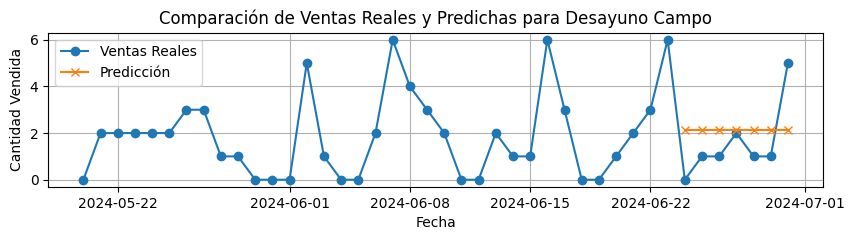

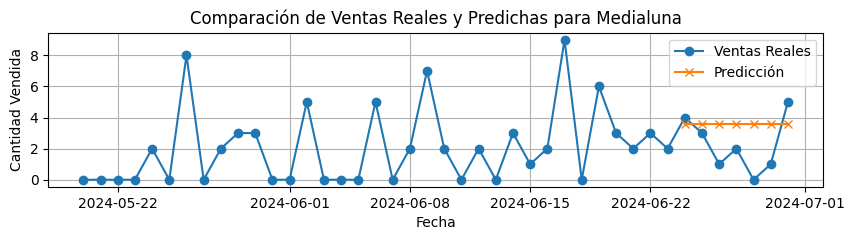

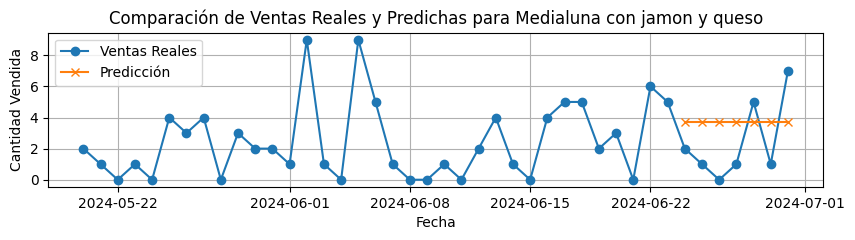

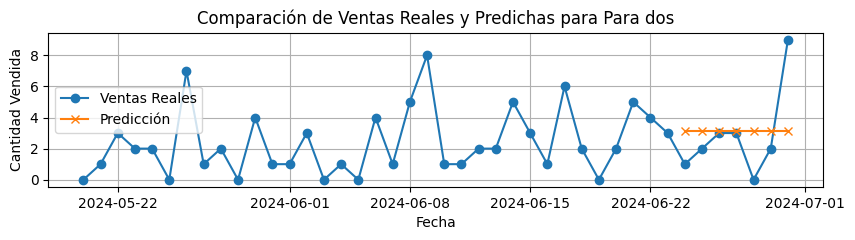

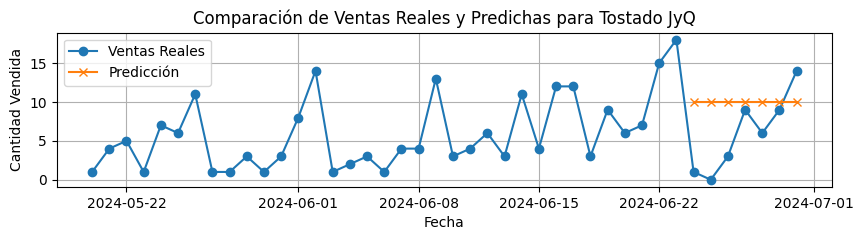

In [52]:
plot_sales_comparison(train_df, test_df, predictions_base)

### Temporal Fusion Transformer

Voy a empezar escalando las columnas numéricas

In [53]:
# Inicio el escalador
scaler = MinMaxScaler()

# Escalo las features numéricas
features_to_scale = ['tempmax', 'tempmin', 'temp', 'precip', 'windspeed', 'cloudcover', 'quantity', 'lag_7', 'lag_365']
df_full[features_to_scale] = scaler.fit_transform(df_full[features_to_scale])


# Guardo el escalador para uso futuro
joblib.dump(scaler, 'scaler.pkl')

df_full.head()

,product,date,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
365,Desayuno Campo,2022-01-01,0.000000,1,0.692722,0.675758,0.826748,0.0,0.469937,0.549,5,1,2022,1,0.000000,0.0
366,Desayuno Campo,2022-01-02,0.230769,0,0.547170,0.809091,0.738602,0.0,0.560127,0.572,6,1,2022,1,0.282051,0.0
367,Desayuno Campo,2022-01-03,0.153846,0,0.749326,0.630303,0.768997,0.0,0.617089,0.719,0,1,2022,0,0.128205,0.0
368,Desayuno Campo,2022-01-04,0.000000,0,0.533693,0.736364,0.671733,0.0,0.531646,0.170,1,1,2022,0,0.000000,0.0
369,Desayuno Campo,2022-01-05,0.102564,0,0.654987,0.651515,0.723404,0.0,0.356013,0.259,2,1,2022,0,0.282051,0.0


In [54]:
df_full.describe().round(1)

,quantity,holiday,tempmax,tempmin,temp,precip,windspeed,cloudcover,weekday,month,year,weekend,lag_7,lag_365
count,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0,4560.0
mean,0.1,0.0,0.4,0.5,0.5,0.0,0.3,0.5,3.0,5.9,2022.8,0.3,0.1,0.2
std,0.1,0.2,0.2,0.2,0.2,0.0,0.2,0.2,2.0,3.4,0.7,0.5,0.1,0.2
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2022.0,0.0,0.0,0.0
25%,0.0,0.0,0.3,0.4,0.4,0.0,0.2,0.3,1.0,3.0,2022.0,0.0,0.0,0.1
50%,0.1,0.0,0.4,0.5,0.5,0.0,0.4,0.4,3.0,6.0,2023.0,0.0,0.1,0.1
75%,0.2,0.0,0.6,0.7,0.7,0.0,0.4,0.6,5.0,9.0,2023.0,1.0,0.2,0.2
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,12.0,2024.0,1.0,1.0,1.0


In [55]:
data = df_full.copy()

# Creo una columna 'time index' basada en la posición de cada fecha
data['time_idx'] = data['date'].rank(method='dense').astype(int) - 1

max_prediction_length = 7
max_encoder_length = 365
training_cutoff = data['time_idx'].max() - max_prediction_length

# Creo el TimeSeriesDataset
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    group_ids=['product'],
    target='quantity',
    time_idx='time_idx',
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['holiday', 'tempmax', 'tempmin',
                              'temp', 'precip', 'windspeed', 'cloudcover',
                              'weekday', 'month', 'year', 'weekend'],
    time_varying_unknown_reals=['quantity']
)

In [56]:
# Conjunto de validación
validation = TimeSeriesDataSet.from_dataset(
    training, 
    data, 
    predict=True,
    stop_randomization=True)

# Creo los dataloaders
batch_size = 64  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=3, persistent_workers=True)

print(f"Tamaño del DataLoader de entrenamiento: {len(train_dataloader.dataset)}")
print(f"Tamaño del DataLoader de validación: {len(val_dataloader.dataset)}")

Tamaño del DataLoader de entrenamiento: 2670
Tamaño del DataLoader de validación: 5


In [57]:
# Callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=1e-4, 
    patience=10, 
    verbose=False, 
    mode="min")

lr_logger = LearningRateMonitor()  # log learning rate

logger = TensorBoardLogger("lightning_logs")

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

# Creo el trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if not torch.cuda.is_available() else torch.cuda.device_count(),
    gradient_clip_val=0.1,
    limit_train_batches=30,  # valiación cada 30 batches
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [58]:
# Creo el modelo TFT
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # número de quantiles
    loss=QuantileLoss(),
    log_interval=10,  # logging cada 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Number of parameters in network: 29.7k


In [59]:
# Entreno el TFT
trainer.fit(
    tft,
    train_dataloader,
    val_dataloader,
)

# Evalúo el TFT
tft_metrics = trainer.validate(tft, val_dataloader)
#print("TFT Metrics:", tft_metrics)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 192    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.2 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │    0.04881380498409271    │
│         val_MAPE          │        616468.8125        │
│         val_RMSE          │    0.06035001203417778    │
│         val_SMAPE         │    0.9271966814994812     │
│         val_loss          │    0.02581370249390602    │
└───────────────────────────┴───────────────────────────┘

In [60]:
val_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

val_predictions

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Prediction(output=Output(prediction=tensor([[[-1.5248e-02,  1.4794e-03,  1.9175e-02,  4.8801e-02,  8.3177e-02,
           1.1843e-01,  1.7136e-01],
         [-2.1217e-02, -1.8210e-02, -1.3827e-02, -4.2509e-03,  2.8807e-03,
           1.1516e-02,  3.7440e-02],
         [-1.5300e-02, -6.4693e-04,  1.5864e-02,  4.1103e-02,  6.8616e-02,
           9.5807e-02,  1.4807e-01],
         [-1.2224e-02,  5.0887e-03,  2.0530e-02,  4.8120e-02,  8.0573e-02,
           1.0896e-01,  1.7178e-01],
         [-1.2691e-02,  5.4729e-03,  1.7991e-02,  4.7345e-02,  8.0962e-02,
           1.0802e-01,  1.7763e-01],
         [-1.5177e-04,  2.1969e-02,  4.5264e-02,  9.2118e-02,  1.3389e-01,
           1.7985e-01,  2.5575e-01],
         [ 2.1293e-03,  2.5316e-02,  5.3305e-02,  9.9737e-02,  1.4410e-01,
           1.9288e-01,  2.7175e-01]],

        [[-5.3921e-02, -2.9555e-02, -3.1897e-03,  4.0596e-02,  9.1502e-02,
           1.4342e-01,  2.2192e-01],
         [-6.2574e-02, -5.8170e-02, -5.1525e-02, -3.7167e-02, -2.6

Grafico

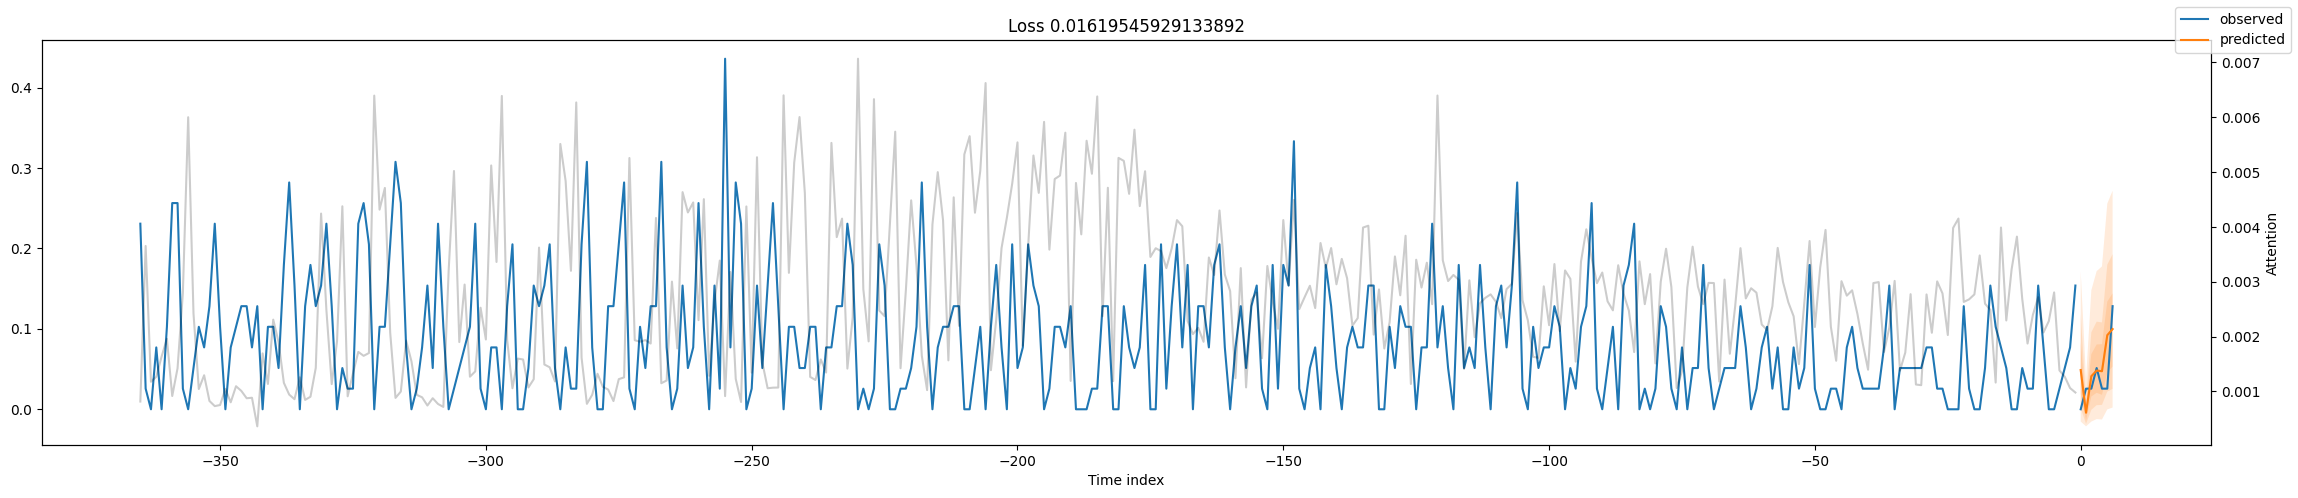

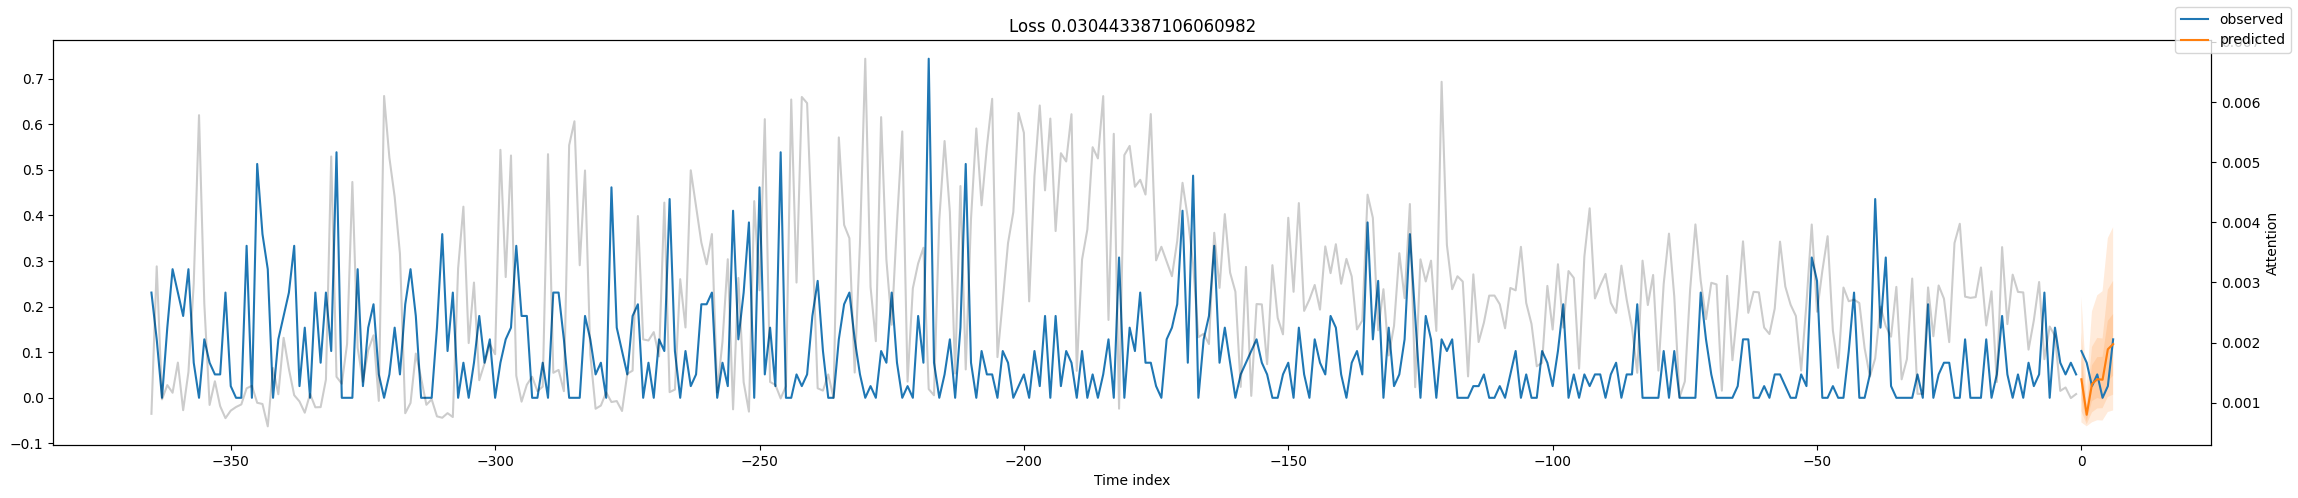

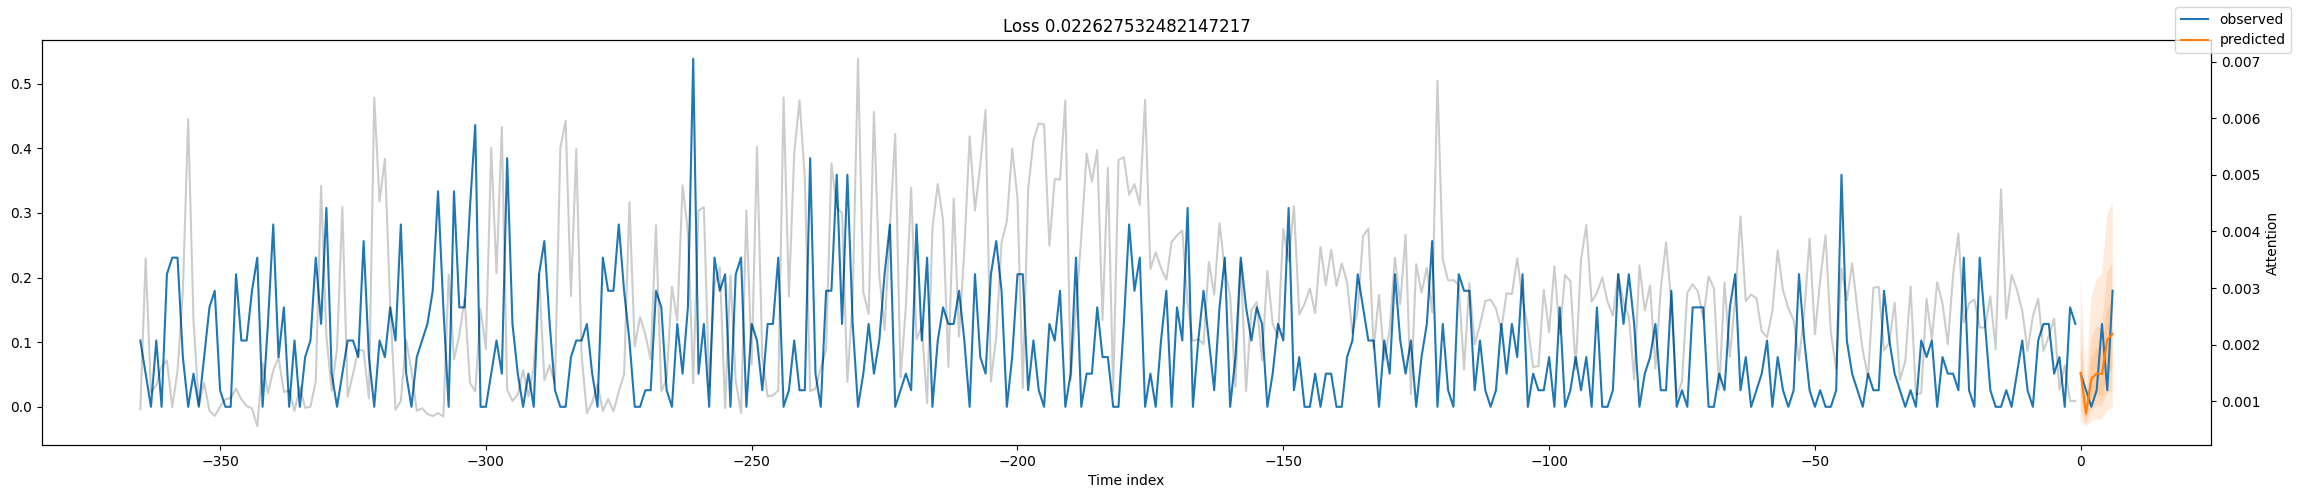

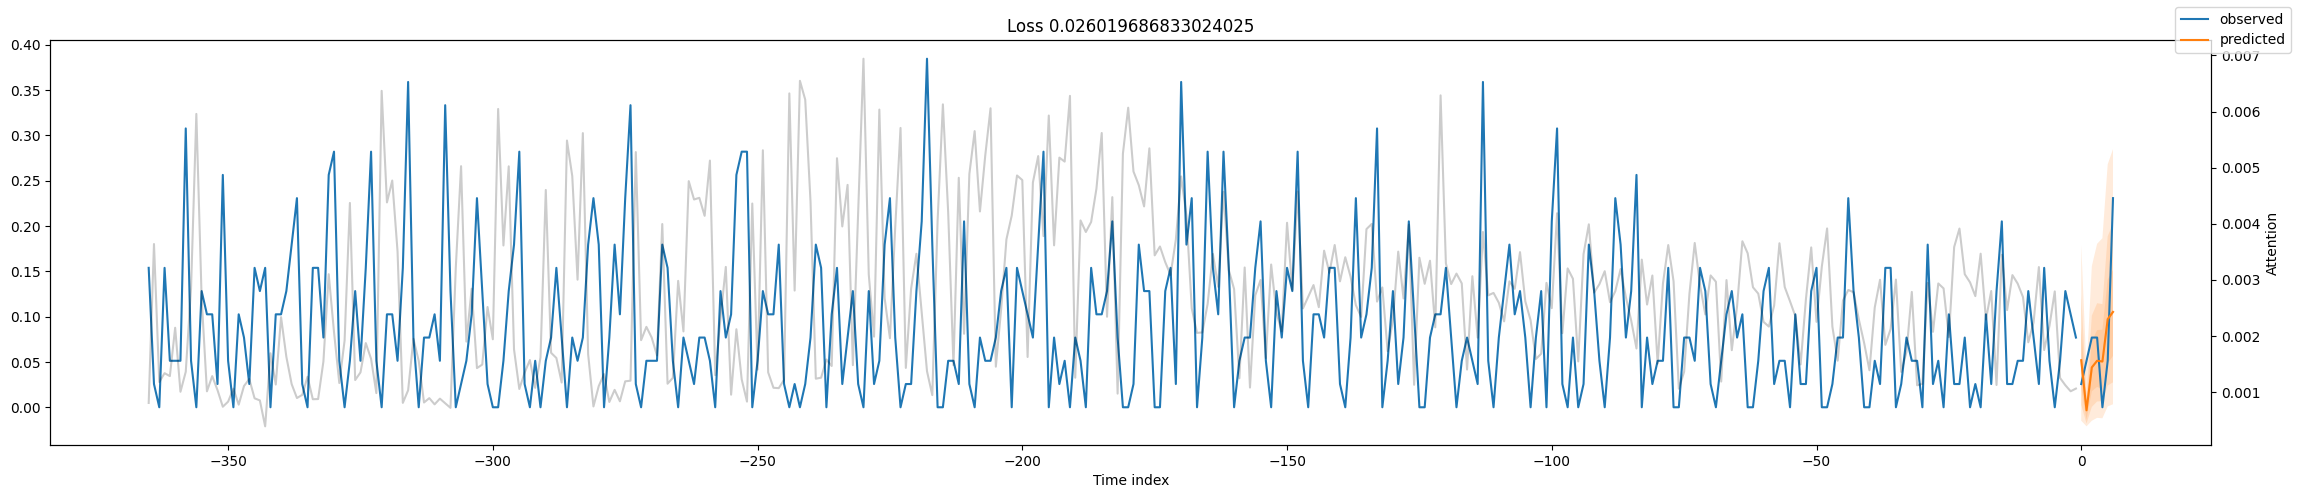

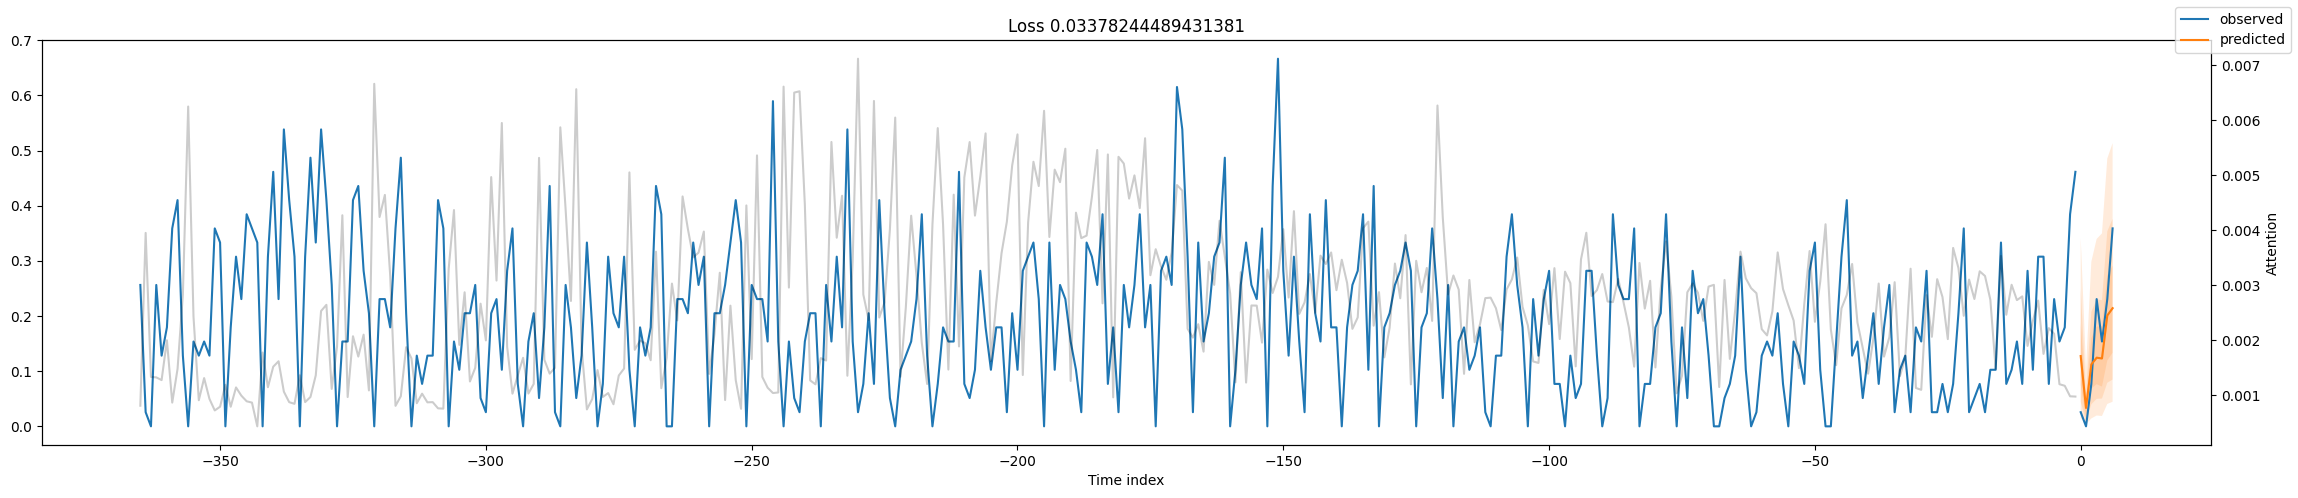

In [61]:
for idx in range(5):
    fig, ax = plt.subplots(figsize=(23,5))
    tft.plot_prediction(val_predictions.x,
                            val_predictions.output,
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

Guardo el modelo

In [62]:
# Guardar tanto el state_dict como la configuración del modelo
model_path = r"C:\\Users\\Usuario\\fudo-to-cloud\\tft.pth"
torch.save({
    'model_state_dict': tft.state_dict(),
    'model_hparams': {
        'learning_rate': tft.hparams.learning_rate,
        'hidden_size': tft.hparams.hidden_size,
        'attention_head_size': tft.hparams.attention_head_size,
        'dropout': tft.hparams.dropout,
        'hidden_continuous_size': tft.hparams.hidden_continuous_size,
        'output_size': tft.hparams.output_size,
        'log_interval': tft.hparams.log_interval,
        'reduce_on_plateau_patience': tft.hparams.reduce_on_plateau_patience,
    }
}, model_path)

Optimización de hiperparámetros

In [ ]:
# import optuna
# from lightning.pytorch import seed_everything, Trainer


# # Función objetivo para Optuna
# def objective(trial):
#     hidden_size = trial.suggest_int("hidden_size", 8, 32, step=8)
#     attention_head_size = trial.suggest_int("attention_head_size", 1, 4)
#     hidden_continuous_size = trial.suggest_int("hidden_continuous_size", 8, 32, step=8)
#     dropout = trial.suggest_float("dropout", 0.1, 0.3, step=0.1)
#     learning_rate = trial.suggest_loguniform("learning_rate", 0.001, 0.1)

#     seed_everything(42)

#     tft = TemporalFusionTransformer.from_dataset(
#         training,
#         learning_rate=learning_rate,
#         hidden_size=hidden_size,
#         attention_head_size=attention_head_size,
#         dropout=dropout,
#         hidden_continuous_size=hidden_continuous_size,
#         output_size=7,  # número de quantiles
#         loss=QuantileLoss(),
#         log_interval=10,
#         reduce_on_plateau_patience=4,
#     )

#     early_stop_callback = EarlyStopping(
#         monitor="val_loss",
#         min_delta=1e-4,
#         patience=10,
#         verbose=False,
#         mode="min")

#     lr_logger = LearningRateMonitor()
#     logger = TensorBoardLogger("lightning_logs")
#     checkpoint_callback = ModelCheckpoint(
#         monitor='val_loss',
#         dirpath='checkpoints',
#         filename='best-checkpoint',
#         save_top_k=1,
#         mode='min'
#     )

#     trainer = Trainer(
#         max_epochs=50,
#         accelerator="gpu" if torch.cuda.is_available() else "cpu",
#         devices=1 if not torch.cuda.is_available() else torch.cuda.device_count(),
#         gradient_clip_val=0.1,
#         limit_train_batches=30,
#         log_every_n_steps=10,
#         callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
#         logger=logger,
#     )

#     trainer.fit(
#         tft,
#         train_dataloader,
#         val_dataloader,
#     )

#     val_metrics = trainer.validate(tft, val_dataloader, verbose=False)
#     return val_metrics[0]['val_loss']

# # Crear el estudio de Optuna
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# # Mostrar los mejores hiperparámetros
# print("Best hyperparameters:", study.best_trial.params)
